In [1]:
import os
from pathlib import Path
import sys

import pandas as pd


sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from src.utils.google_connection import set_up_google_connection

In [2]:
credentials_path = Path('../credentials/cool-plasma-452619-v4-feb20b70d461.json')

In [3]:
client, service = set_up_google_connection(credentials_path)

In [4]:
spreadsheet = client.open_by_key(
    '1OnrW1foE-1lOtgfxBv2Y5qqJSDnW4hiYeLpScjgFKxM'
)  # TODO: Put in secrets/env

sheet_incomes = spreadsheet.worksheet('Einnahmen')
sheet_expenses = spreadsheet.worksheet('Ausgaben')

df_expenses = pd.DataFrame(sheet_expenses.get_all_values())
df_incomes = pd.DataFrame(sheet_incomes.get_all_values())

In [5]:
df_expenses.columns = df_expenses.iloc[0]
df_expenses = df_expenses[1:].reset_index(drop=True)

df_incomes.columns = df_incomes.iloc[0]
df_incomes = df_incomes[1:].reset_index(drop=True)

gsheets = {'Expense': df_expenses, 'Income': df_incomes}

In [6]:
gsheets['Income'].head()

,Wer,Kategorie,01,02,03,04,05,06,07,08,09,10,11,12,Hinweis
0,Jan Leonardo Rütten,Aktivität,"36,00",,,,,,,,,,,,Tickets Fußball
1,Deutsche Telekom AG,Gehalt,"1141,25",,,,,,,,,,,,
2,VR-BANK BONN RHEIN-SIEG,Einzahlung,"955,00",,,,,,,,,,,,
3,Renten Service,Waisenrente,"22,92",,,,,,,,,,,,
4,Deutsche Post AG,Waisenrente,"305,55",,,,,,,,,,,,


In [7]:
month_cols = [f'{i:02}' for i in range(1, 13)]

# Alles außer Ziffern und Komma/Punkt rauswerfen, dann zu Zahl
gsheets['Income'][month_cols] = (
    gsheets['Income'][month_cols]
    .replace(r'[^0-9,.-]', '', regex=True)  # Währungen, Leerzeichen, etc. entfernen
    .replace(',', '.', regex=True)  # Kommas durch Punkt ersetzen (falls Kommazahlen)
    .apply(pd.to_numeric, errors='coerce')  # endlich in float/int umwandeln
)

# Alles außer Ziffern und Komma/Punkt rauswerfen, dann zu Zahl
gsheets['Expense'][month_cols] = (
    gsheets['Expense'][month_cols]
    .replace(r'[^0-9,.-]', '', regex=True)  # Währungen, Leerzeichen, etc. entfernen
    .replace(',', '.', regex=True)  # Kommas durch Punkt ersetzen (falls Kommazahlen)
    .apply(pd.to_numeric, errors='coerce')  # endlich in float/int umwandeln
)

In [8]:
gsheets['Income'].head()

,Wer,Kategorie,01,02,03,04,05,06,07,08,09,10,11,12,Hinweis
0,Jan Leonardo Rütten,Aktivität,36.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tickets Fußball
1,Deutsche Telekom AG,Gehalt,1141.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
2,VR-BANK BONN RHEIN-SIEG,Einzahlung,955.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
3,Renten Service,Waisenrente,22.92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
4,Deutsche Post AG,Waisenrente,305.55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,


In [9]:
gsheets['Income'].dtypes

0
Wer           object
Kategorie     object
01           float64
02           float64
03           float64
04           float64
05           float64
06           float64
07           float64
08           float64
09           float64
10           float64
11           float64
12           float64
Hinweis       object
dtype: object

In [10]:
gsheets['Income']['Kategorie'].unique()

array(['Aktivität', 'Gehalt', 'Einzahlung', 'Waisenrente', 'Geschenk',
       'Essen', 'Autoverkauf', 'Heuser GmbH', 'Dividende', 'Urlaub',
       'Entnahme'], dtype=object)

# Questions to answer (Each Income and Expense)

- What is the sum of each month? -> Bar Chart
- What is the sum of each category? -> Pie chart

In [11]:
import matplotlib.pyplot as plt

## What is the sum of each month?

In [ ]:
# Income
income_per_month = gsheets['Income'][month_cols].sum()
df_income_per_month = pd.DataFrame([income_per_month], index=['Income'])

# Expense
expense_per_month = gsheets['Expense'][month_cols].sum()
df_expense_per_month = pd.DataFrame([expense_per_month], index=['Expense'])

df_all_sums = pd.concat([df_income_per_month, df_expense_per_month])
df_all_sums

,01,02,03,04,05,06,07,08,09,10,11,12
Income,2460.72,11812.72,1713.81,1898.91,1590.36,2227.81,1587.21,1629.08,0.0,0.0,0.0,0.0
Expense,1699.57,12589.17,1553.05,1379.34,1804.82,3078.81,1244.64,1394.51,0.0,0.0,0.0,0.0


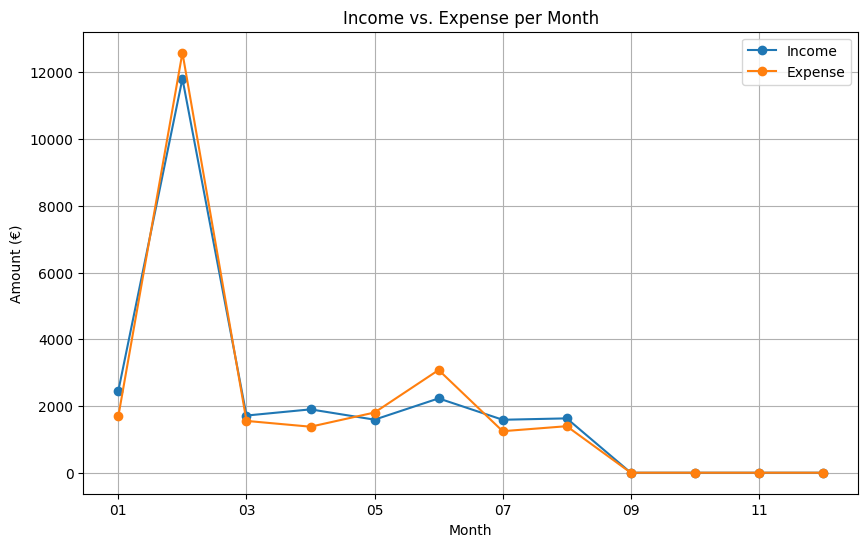

In [13]:
# 1️⃣ Linien-Chart: Verlauf über Monate
df_all_sums.T.plot(kind='line', marker='o', figsize=(10, 6))
plt.title('Income vs. Expense per Month')
plt.xlabel('Month')
plt.ylabel('Amount (€)')
plt.grid(True)
plt.show()

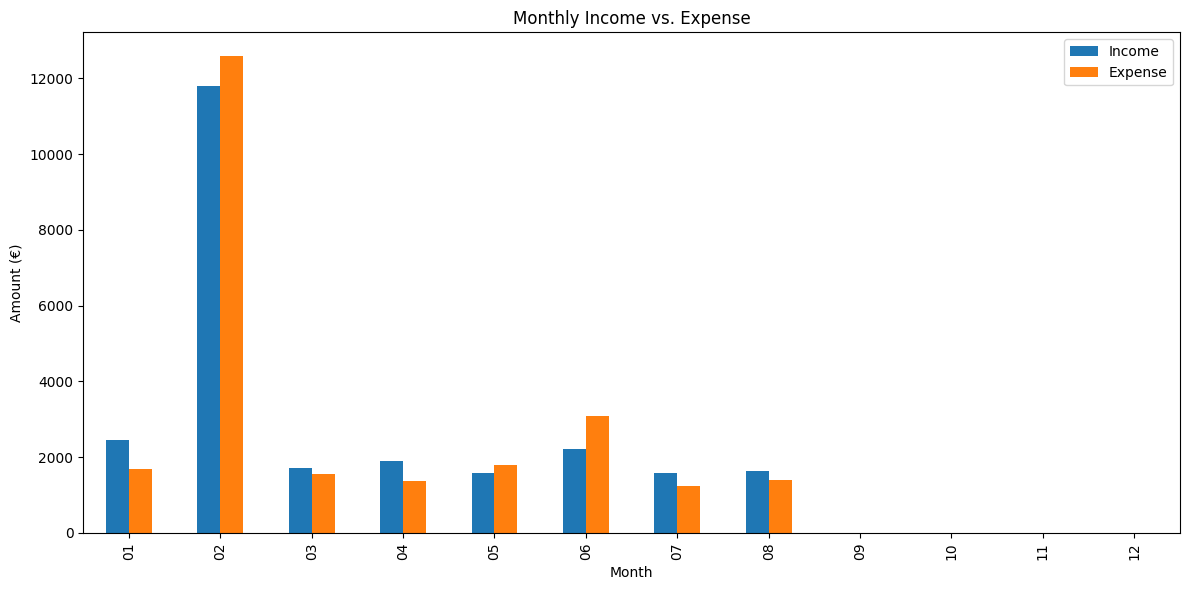

In [14]:
# 2️⃣ Balken-Chart: Income vs Expense je Monat
df_all_sums.T.plot(kind='bar', figsize=(12, 6))
plt.title('Monthly Income vs. Expense')
plt.xlabel('Month')
plt.ylabel('Amount (€)')
plt.legend(title='')
plt.tight_layout()
plt.show()

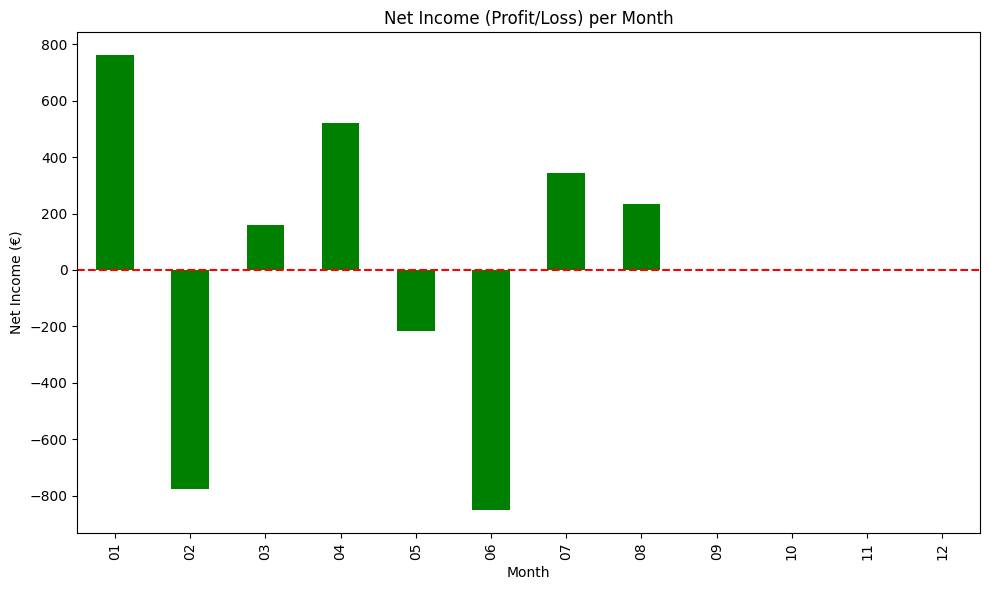

In [15]:
# 3️⃣ Gewinn (Income - Expense)
(df_all_sums.loc['Income'] - df_all_sums.loc['Expense']).plot(
    kind='bar', color='green', figsize=(10, 6)
)
plt.axhline(0, color='red', linestyle='--')
plt.title('Net Income (Profit/Loss) per Month')
plt.xlabel('Month')
plt.ylabel('Net Income (€)')
plt.tight_layout()
plt.show()

Income        24920.62
Expense       24743.91
Net Income      176.71
dtype: float64


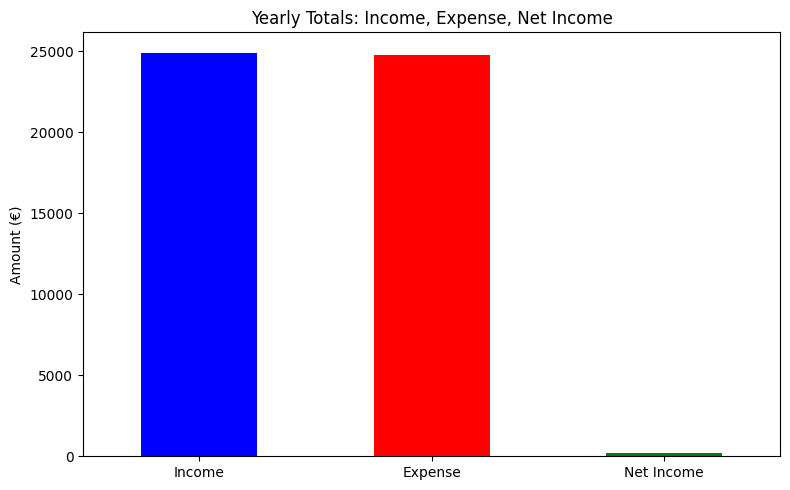

In [16]:
# 1️⃣ Gesamtsummen berechnen
totals = df_all_sums.sum(axis=1)
totals['Net Income'] = totals['Income'] - totals['Expense']

print(totals)

# 2️⃣ Balkendiagramm für Jahreswerte
totals.plot(kind='bar', color=['blue', 'red', 'green'], figsize=(8, 5))
plt.title('Yearly Totals: Income, Expense, Net Income')
plt.ylabel('Amount (€)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## What is the sum of each category?

### Income

In [17]:
income_per_cat = gsheets['Income'].groupby('Kategorie')[month_cols].sum()
income_per_cat['Total'] = income_per_cat.sum(axis=1)
df_income = income_per_cat.reset_index()[['Kategorie', 'Total']]

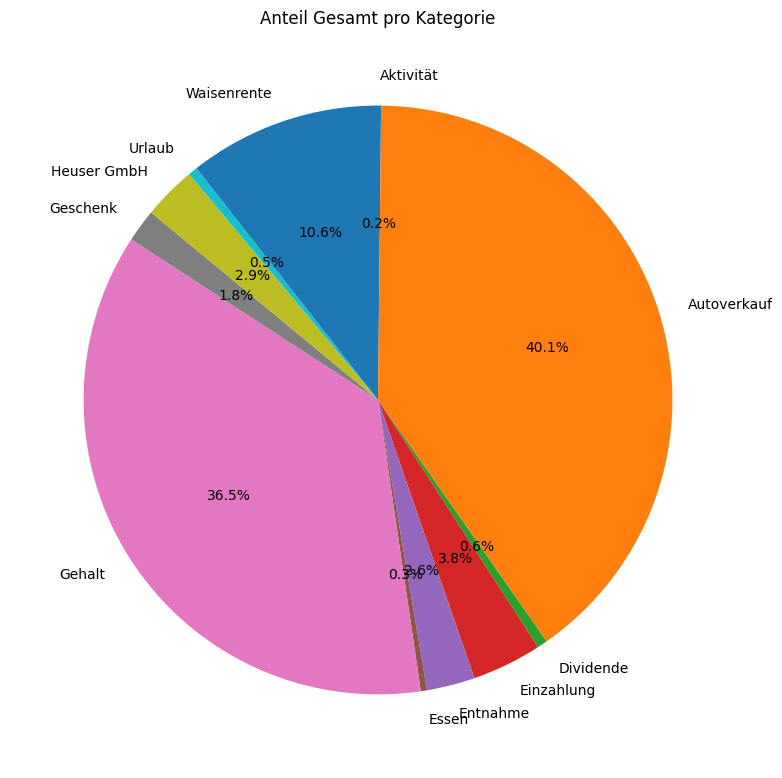

In [18]:
# PieChart zeichnen
plt.figure(figsize=(8, 8))
plt.pie(
    df_income['Total'],
    labels=df_income['Kategorie'],
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False,
)
plt.title('Anteil Gesamt pro Kategorie')
plt.tight_layout()
plt.show()

### Expense

In [19]:
expense_per_cat = gsheets['Expense'].groupby('Kategorie')[month_cols].sum()
expense_per_cat['Total'] = expense_per_cat.sum(axis=1)
df_expense = expense_per_cat.reset_index()[['Kategorie', 'Total']]

In [23]:
df_expense.sort_values(by='Total', ascending=False)

,Kategorie,Total
2,Auto,8430.74
16,Umbuchung,5000.00
13,Sparen,3200.00
15,Sport,2482.94
6,Investieren,2440.00
8,Klamotten,618.20
18,Urlaub,466.20
3,Einkaufen,403.53
1,Aktivität,347.41
4,Geschenk,336.25


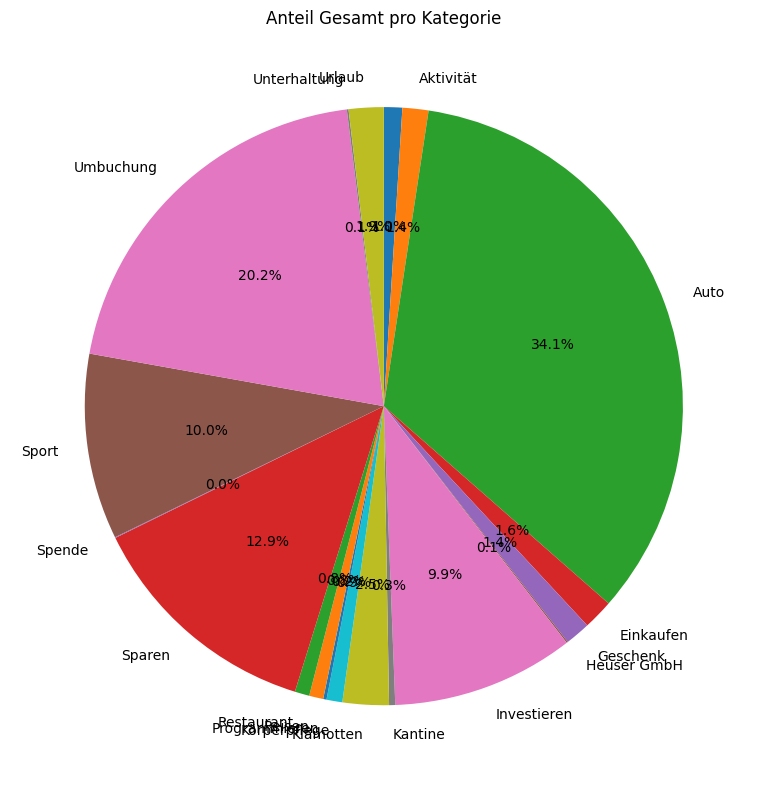

In [20]:
# PieChart zeichnen
plt.figure(figsize=(8, 8))
plt.pie(
    df_expense['Total'],
    labels=df_expense['Kategorie'],
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False,
)
plt.title('Anteil Gesamt pro Kategorie')
plt.tight_layout()
plt.show()